# 神经网络全连接实现方法
1. 直接通过numpy实现
2. 通过pytorch实现

## 1.问题描述
训练集为(X,y)，并满足：$ y = WX + random(very-small) $ ,X维度为1000并且变量的最高次数为1,样本大小为600 。现要求通过训练BP神经网络得到等效的$W$。

## 2.解决方案
1. 形成有一层隐含层的BP神经网络，维度为200
2. 数据的80%用于训练，20%用于验证

## 3.numpy方案

### 3.1数据生成

In [1]:
import numpy as np
#维度和大小参数定义
batch_size = 600
input_dim = 100
output_dim = 1
hidden_dim = 50

# 数据虚拟 (x,y)
X = np.random.randn(input_dim,batch_size)
W = np.random.randn(output_dim,input_dim)
y = np.dot(W,X) + np.random.randn(1,batch_size)/10000 #添加偏差项
print(X.shape,W.shape,y.shape)

(100, 600) (1, 100) (1, 600)


### 3.2训练集以及验证集的生成

In [2]:
#Sigmoid函数
def Sigm(X):
    return np.clip(1 / (1.0 + np.exp(-X)), 1e-8, 1 - (1e-8))

#数据正规化
def _normalize(X):
    X_nor  = np.zeros((X.shape[0],X.shape[1]),dtype=float)
    X_mean = np.mean(X,1)
    X_std  = np.std(X,1)
    for i in range(X.shape[1]):
        X_nor[:,i] = (X[:,i] - X_mean)/X_std
    return X_nor

In [3]:
data_to_t = 0.8
k = int(data_to_t*batch_size)

X = _normalize(X)
y = _normalize(y)
X_train = X[:,0:int(k)]
y_train = y[:,0:int(k)]
X_test = X[:,int(k):batch_size]
y_test = y[:,int(k):batch_size]

## 3.3网络生成

In [4]:
w1 = np.random.randn(input_dim,hidden_dim)
w2 = np.random.randn(hidden_dim,output_dim)
b1 = np.random.randn(1,hidden_dim)
b2 = np.random.randn(1,output_dim)
x1 = np.ones((1,X_train.shape[1]))
x2 = np.ones((1,X_test.shape[1]))
w1_h = np.concatenate((w1,b1),axis=0)
w2_h = np.concatenate((w2,b2),axis=0)
X_train = np.concatenate((X_train,x1),axis=0)
X_test = np.concatenate((X_test,x2),axis=0)

w1.shape,w2.shape,w1_h.shape,w2_h.shape,X_train.shape,X_test.shape

((100, 50), (50, 1), (101, 50), (51, 1), (101, 480), (101, 120))

In [5]:
x1.shape,x2.shape

((1, 480), (1, 120))

### 3.4超参数

In [6]:
#学习率
lr = 1e-1

### 3.5网络训练
注意点：

    1.采用Sigmoid激活函数。
    2.所有数据进行正规化 
    3.loss函数采用平方损失函数

In [7]:
def NNT(X,W1_h,W2_h):
    z = np.dot(W1_h.T,X)
    A = Sigm(z)
    a = np.ones((1,A.shape[1]))
    Ah = np.concatenate((A,a),axis=0)
    y = np.dot(W2_h.T,Ah)
    return z,A,y,Ah

def Loss(y,y_train):
    return (1/(2*y_train.shape[1]))*np.dot((y - y_train),(y - y_train).T)

def dSigm(X):#sigmoid函数的导数
    return np.exp(-X) / (1.0 + np.exp(-X))**2

def list_to_eye(X):
    Xe = np.zeros((X.size,X.size))
    for i in range(0,X.size):
        Xe[i,i] = X[i]
    return Xe

def grad_1(y,y_train,X_train,W2,z):
    S = np.zeros((X_train.shape[0],W2.shape[0]))
    for i in range(0,y_train.shape[1]):
        S = S + (y[0,i] - y_train[0,i])*np.dot(np.dot(X_train[:,i].reshape(-1,1),w2.T),list_to_eye(dSigm(z[:,i]).reshape(-1,1)))
    return S/y_train.shape[1]

def grad_2(y,y_train,Ah):
    S = np.zeros((y.shape[0],1))
    for i in range(0,y.shape[1]):
        S = S + (y[0,i] - y_train[0,i])*Ah[:,1].reshape(-1,1)
    return S/y_train.shape[1]

In [8]:
loss = []
num =[]
for i in range(0,1000):
    z,a,y,ah = NNT(X_train,w1_h,w2_h)
    w1_h = w1_h - lr * grad_1(y,y_train,X_train,w2,z)
    w2_h = w2_h - lr * grad_2(y,y_train,ah)
    loss.append(Loss(y,y_train))
    num.append(i)
    if loss[-1] < 1:
        break

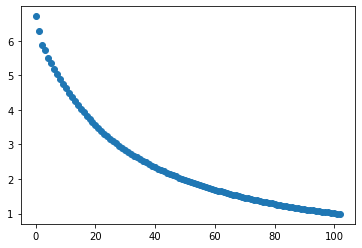

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

num = np.array(num).reshape(1,-1)
loss = np.array(loss).reshape(1,-1)
plt.scatter(num,loss)
plt.show()